# ChIP features distributed within TADs

How many TADs with dysregulated genes contain a ChIP feature?

***Plots:*** 
* Bar Graph: Proportion of TADs with differing ChIP peaks containing at least one DE gene
* Histogram: Cumulative portion of ChIP peaks within a TAD

In [1]:
import plotting_histogram_functions as pfn
import filter_gene_functions as flt

In [2]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bioframe as bf
from gtfparse import read_gtf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Load data and project files

In [4]:
day1_res_df = flt.load_tss_df()
day1_res_df = flt.label_DE_status(day1_res_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


## Plotting counts of TADs containing a dysregulated gene and some number of ChIP feature counts

In [5]:
# Load Chip-Seq files 
chip_folder = "/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/"

ctcf = "CTCF_peaks_called_on_4reps_foundInatLeast2reps_noBlacklist.bed"
rad21 = "RAD21_peaks_called_on_6reps_foundInatLeast3reps_noBlacklist.bed"
nipbl = "Nipbl_112.175.197.114.177.196_peaks.xls.bed"
promoter = "H3K27ac_EA92-97_peaks.xls.bed"

chip_peaks_condition_dict = {'CTCF' : chip_folder+ctcf, 'RAD21' : chip_folder+rad21,
                           'NIPBL' : chip_folder+nipbl, 'H3K27ac' : chip_folder+promoter}

In [6]:
feature_dir = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features'
insulation_table = pd.read_table(feature_dir+'/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation')

# Defining TADs using midpoints between boundaries
tad_mid_df = flt.tad_windows_from_boundaries(insulation_table, take_midpoint=True)

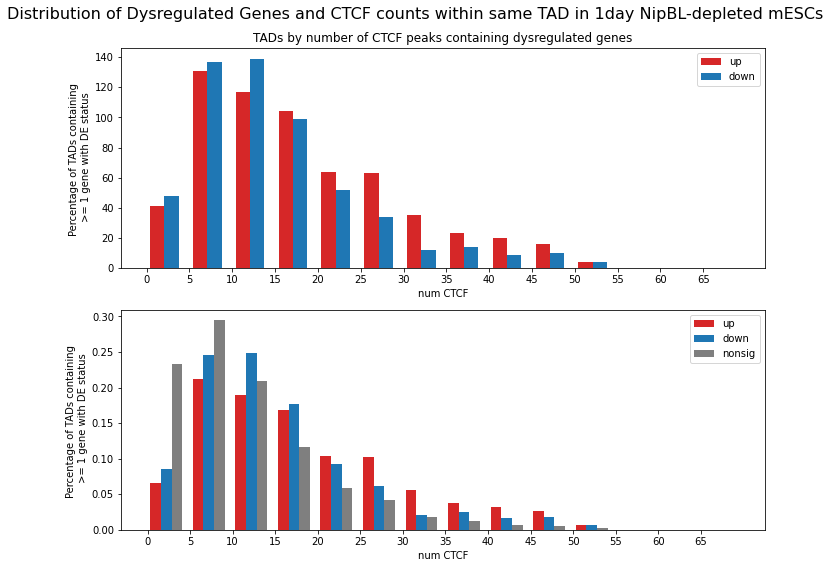

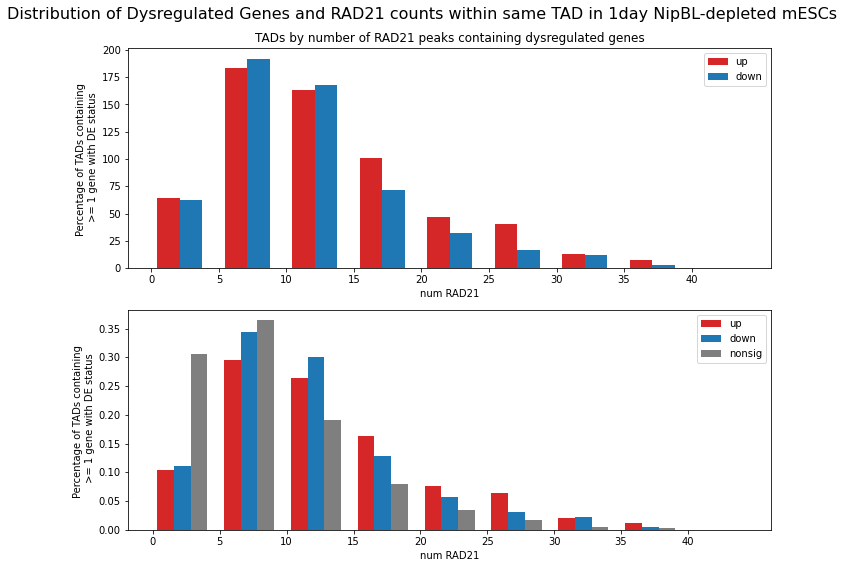

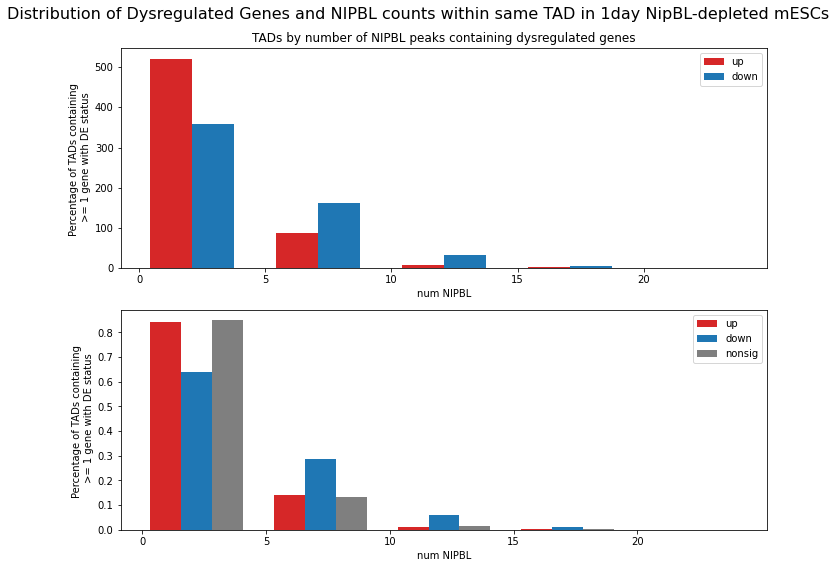

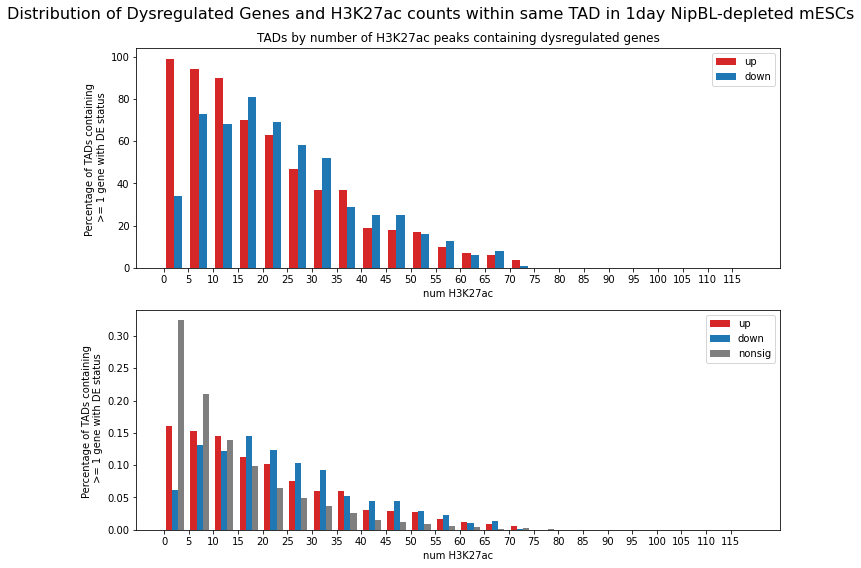

In [7]:
genes_cutoff=1
bin_size=5
for (feat, file) in chip_peaks_condition_dict.items():

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    fig.suptitle(('Distribution of Dysregulated Genes and '
                '{} counts within same TAD in 1day NipBL-depleted mESCs'.
                format(feat)),
                fontsize=16)

    # Annotate number of enhancers within the tad
    df = tad_mid_df.copy()
    chip_df = flt.get_peak_bioframe(file)
    df['num_'+feat] = bf.count_overlaps(df, chip_df)['count']
    
    pfn.distribution_regions_by_features(df,
                                day1_res_df,
                                region_group_col='num_'+feat,
                                plot_title='TADs by number of {} peaks containing dysregulated genes'.format(feat),
                                feature_category_colors={"up": 'tab:red', 
                                                    "down": 'tab:blue'},
                                percentage=False,
                                num_genes_cutoff=genes_cutoff,
                                bin_size=bin_size,
                                ax=axs[0]
                                )
                                
    pfn.distribution_regions_by_features(df,
                                day1_res_df,
                                region_group_col='num_'+feat,
                                percentage=True,
                                num_genes_cutoff=genes_cutoff,
                                bin_size=bin_size,
                                ax=axs[1]
                                )
    
    plt.tight_layout()
    plt.show()

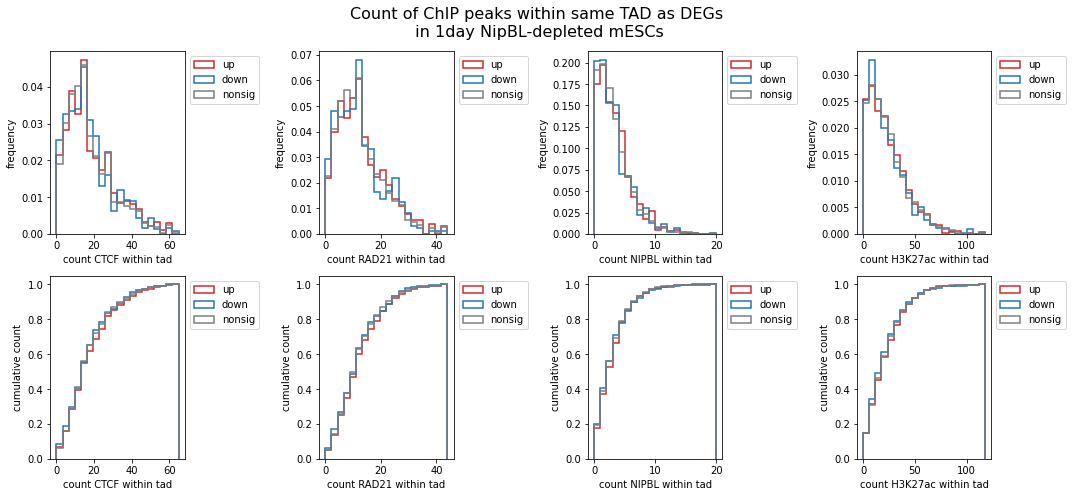

In [8]:
fig, axs = plt.subplots(2, len(chip_peaks_condition_dict), figsize=(15, 7))

i = 0
for chip, file in chip_peaks_condition_dict.items():
    ctcf_df = flt.get_peak_bioframe(file)
    df['count_'+chip+'_peaks'] = bf.count_overlaps(df, ctcf_df)['count']
    day1_res_df['count_'+chip+'_within_tad'] = bf.overlap(day1_res_df, df, how='inner', suffixes=('_genes', '_tads'))['count_'+chip+'_peaks_tads']

    fig.suptitle(('Count of ChIP peaks within same TAD as DEGs'
                 '\n in 1day NipBL-depleted mESCs'),
                 fontsize=16)

    pfn.plot_count_histogram(day1_res_df,
                         'count_'+chip+'_within_tad',
                        cumulative=True,
                         bins=20,
                        ax=axs[1, i])

    pfn.plot_count_histogram(day1_res_df,
                         'count_'+chip+'_within_tad',
                        cumulative=False,
                        bins=20,
                        ax=axs[0, i])
    i+=1


plt.tight_layout()
plt.show()